In [1]:
import pandas as pd
import pm4py
from helpers import get_field_position
from pm4py.objects.ocel.util.log_ocel import log_to_ocel_multiple_obj_types as log_to_ocel

 Object Type         | Description                                                           
 ------------------- | --------------------------------------------------------------------- 
 `Team`              | The team associated with the event.                                   
 `From`              | The player in possession of the ball at the start of the event.       
 `To`                | The player in possession of the ball at the end of the event if the ownership changed.|
 `case:concept:name` | Unique ID for each case--an attack. 'AA' indicates away team attack, 'HA' indicates home team attack    
 `end_grid`          | The grid zone where the event ends.                              
 ------------------- | --------------------------------------------------------------------- 
 Attribute                      | Description                                               
 `attribute:subtype`            | Event subtype (e.g. `"PASS"`, `"GOAL"`, `"SHOT"`). For details please refer to the data documentation.     
 `attribute:start_x`, `start_y` | X/Y coordinates of the ball at the start of the event.        
 `attribute:end_x`, `end_y`     | X/Y coordinates of the ball at the end of the event.          
 `attribute:duration`           | Duration (in seconds) of the event.                           
 `attribute:travel_distance`    | Distance traveled by the ball.                                
 `attribute:start_grid`         | Grid ID where the event begins.                               
 `attribute:crossed_grid`       | If the event start in one grid and ends in another.           
 `attribute:attack_game`        | Identifier for attack sequence. Combined count of both team. 
 `attribute:attack_successful`  | Boolean flag — `True` if the attack led to a goal.            
 `attribute:home_team_score`    | Cumulative score of the home team at this point in the match.
 `attribute:away_team_score`    | Cumulative score of the away team at this point in the match. 


In [ ]:
# settings
## Resolution of the grid
x_fields = 10
y_fields = 10

In [ ]:
#load event data and preprocessing
df = pd.read_csv('sample-data\data\Sample_Game_1\Sample_Game_1_RawEventsData.csv')
#df['case:concept:name'] = df.index.astype(str)
df['timestamp'] = pd.to_datetime(df['Start Time [s]'], unit='s', origin='unix')
df['attribute:duration'] = df['End Time [s]'] - df['Start Time [s]']
#df['player']= df.apply(lambda row: [row["From"], row["To"]], axis=1)
df['attribute:travel_distance'] = ((df['End X'] - df['Start X'])**2 + (df['End Y'] - df['Start Y'])**2)**0.5
df['attribute:start_grid'] = df.apply(lambda row: [get_field_position(row["Start X"], row["Start Y"], x_fields=x_fields, y_fields=y_fields)], axis=1)
df['end_grid'] = df.apply(lambda row: [get_field_position(row["End X"], row["End Y"], x_fields=x_fields, y_fields=y_fields)], axis=1)
df['attribute:crossed_grid'] = df['attribute:start_grid'] != df['end_grid']
df['attribute:attack_game'] = ((df['Type'] == 'SET PIECE') | (df['Type'] == 'RECOVERY')).cumsum()

attack_id_away = 0
attack_id_home = 0
current_team = None
attack_ids = []
for i, row in df.iterrows():
    event = row['Type']
    if event in ['SET PIECE', 'RECOVERY']:
        current_team = row['Team']
        if current_team == 'Away':
            attack_id_away += 1
            attack_id = 'AA'+str(attack_id_away)
        else:
            attack_id_home += 1
            attack_id = 'HA'+str(attack_id_home)
    attack_ids.append(attack_id)

df['attack_team'] = attack_ids

df['attribute:attack_successful'] = False
goal_indices = df[df['Subtype'].str.endswith('GOAL', na=False)].index
successful_cases = df.loc[goal_indices, 'attack_team'].unique()
df.loc[df['attack_team'].isin(successful_cases), 'attribute:attack_successful'] = True

df.rename(columns={
    'Type': 'concept:name',
    'attack_team': 'case:concept:name',
    'timestamp': 'time:timestamp',
    'Subtype': 'attribute:subtype',
    'Start X': 'attribute:start_x',
    'Start Y': 'attribute:start_y',
    'End X': 'attribute:end_x',
    'End Y': 'attribute:end_y'
}, inplace=True)

#calculates team scores
df['home_goal'] = (
    df['attribute:subtype'].str.endswith('GOAL', na=False) &
    df['case:concept:name'].str.startswith('HA')
).astype(int)

df['away_goal'] = (
    df['attribute:subtype'].str.endswith('GOAL', na=False) &
    df['case:concept:name'].str.startswith('AA')
).astype(int)

df['attribute:home_team_score'] = df['home_goal'].cumsum()
df['attribute:away_team_score'] = df['away_goal'].cumsum()

df.drop(columns=['home_goal', 'away_goal'], inplace=True)
#df.to_csv('sample-data\data\Sample_Game_1\Sample_Game_1_RawEventsData_ocel.csv', index=False)

In [3]:
#df = pm4py.format_dataframe(df, case_id='case:concept:name', activity_key='Activity', timestamp_key='Timestamp')
event_log = pm4py.convert_to_event_log(df)

In [4]:
ocel= log_to_ocel(event_log, activity_column='concept:name'
                  , timestamp_column='time:timestamp', obj_types=['Team','From', 'To','case:concept:name', 'end_grid']
                  ,additional_event_attributes=['attribute:subtype', 'attribute:start_x', 'attribute:start_y'
                                                , 'attribute:end_x', 'attribute:end_y' 
                                                , 'attribute:duration', 'attribute:travel_distance', 'attribute:start_grid'
                                                , 'attribute:crossed_grid', 'attribute:attack_game', 'attribute:attack_successful'
                                                , 'attribute:home_team_score', 'attribute:away_team_score'                                                
                                                ])

In [5]:
ocel.get_extended_table()

,ocel:eid,ocel:activity,ocel:timestamp,attribute:subtype,attribute:duration,attribute:start_grid,attribute:crossed_grid,attribute:attack_game,attribute:attack_successful,attribute:home_team_score,attribute:away_team_score,attribute:start_x,attribute:start_y,attribute:end_x,attribute:end_y,attribute:travel_distance,ocel:type:Team,ocel:type:From,ocel:type:case:concept:name,ocel:type:To
0,0,SET PIECE,1970-01-01 00:00:00.040,KICK OFF,-0.04,[None],False,1,False,0,0,NaN,NaN,NaN,NaN,NaN,[Away],[Player19],[AA1],NaN
1,1,PASS,1970-01-01 00:00:00.040,NaN,0.08,[E4],True,1,False,0,0,0.45,0.39,0.55,0.43,0.107703,[Away],[Player19],[AA1],[Player21]
2,2,PASS,1970-01-01 00:00:00.120,NaN,0.56,[F5],True,1,False,0,0,0.55,0.43,0.58,0.21,0.222036,[Away],[Player21],[AA1],[Player15]
3,3,PASS,1970-01-01 00:00:01.800,NaN,0.64,[F2],True,1,False,0,0,0.55,0.19,0.45,0.31,0.156205,[Away],[Player15],[AA1],[Player19]
4,4,PASS,1970-01-01 00:00:03.080,NaN,0.76,[E4],True,1,False,0,0,0.45,0.32,0.49,0.47,0.155242,[Away],[Player19],[AA1],[Player21]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740,1740,PASS,1970-01-01 01:35:34.440,NaN,4.88,[G4],True,354,False,4,0,0.60,0.33,0.19,0.95,0.743303,[Home],[Player12],[HA180],[Player13]
1741,1741,PASS,1970-01-01 01:35:43.120,NaN,0.60,[A9],True,354,False,4,0,0.09,0.88,0.14,0.69,0.196469,[Home],[Player13],[HA180],[Player4]
1742,1742,BALL LOST,1970-01-01 01:35:43.920,INTERCEPTION,0.80,[B7],True,354,False,4,0,0.13,0.69,0.07,0.61,0.100000,[Home],[Player4],[HA180],NaN
1743,1743,RECOVERY,1970-01-01 01:35:44.680,BLOCKED,0.00,[A7],True,355,False,4,0,0.05,0.62,NaN,NaN,NaN,[Away],[Player16],[AA175],NaN


In [6]:
path = "game1.jsonocel"
pm4py.write_ocel(ocel, path)

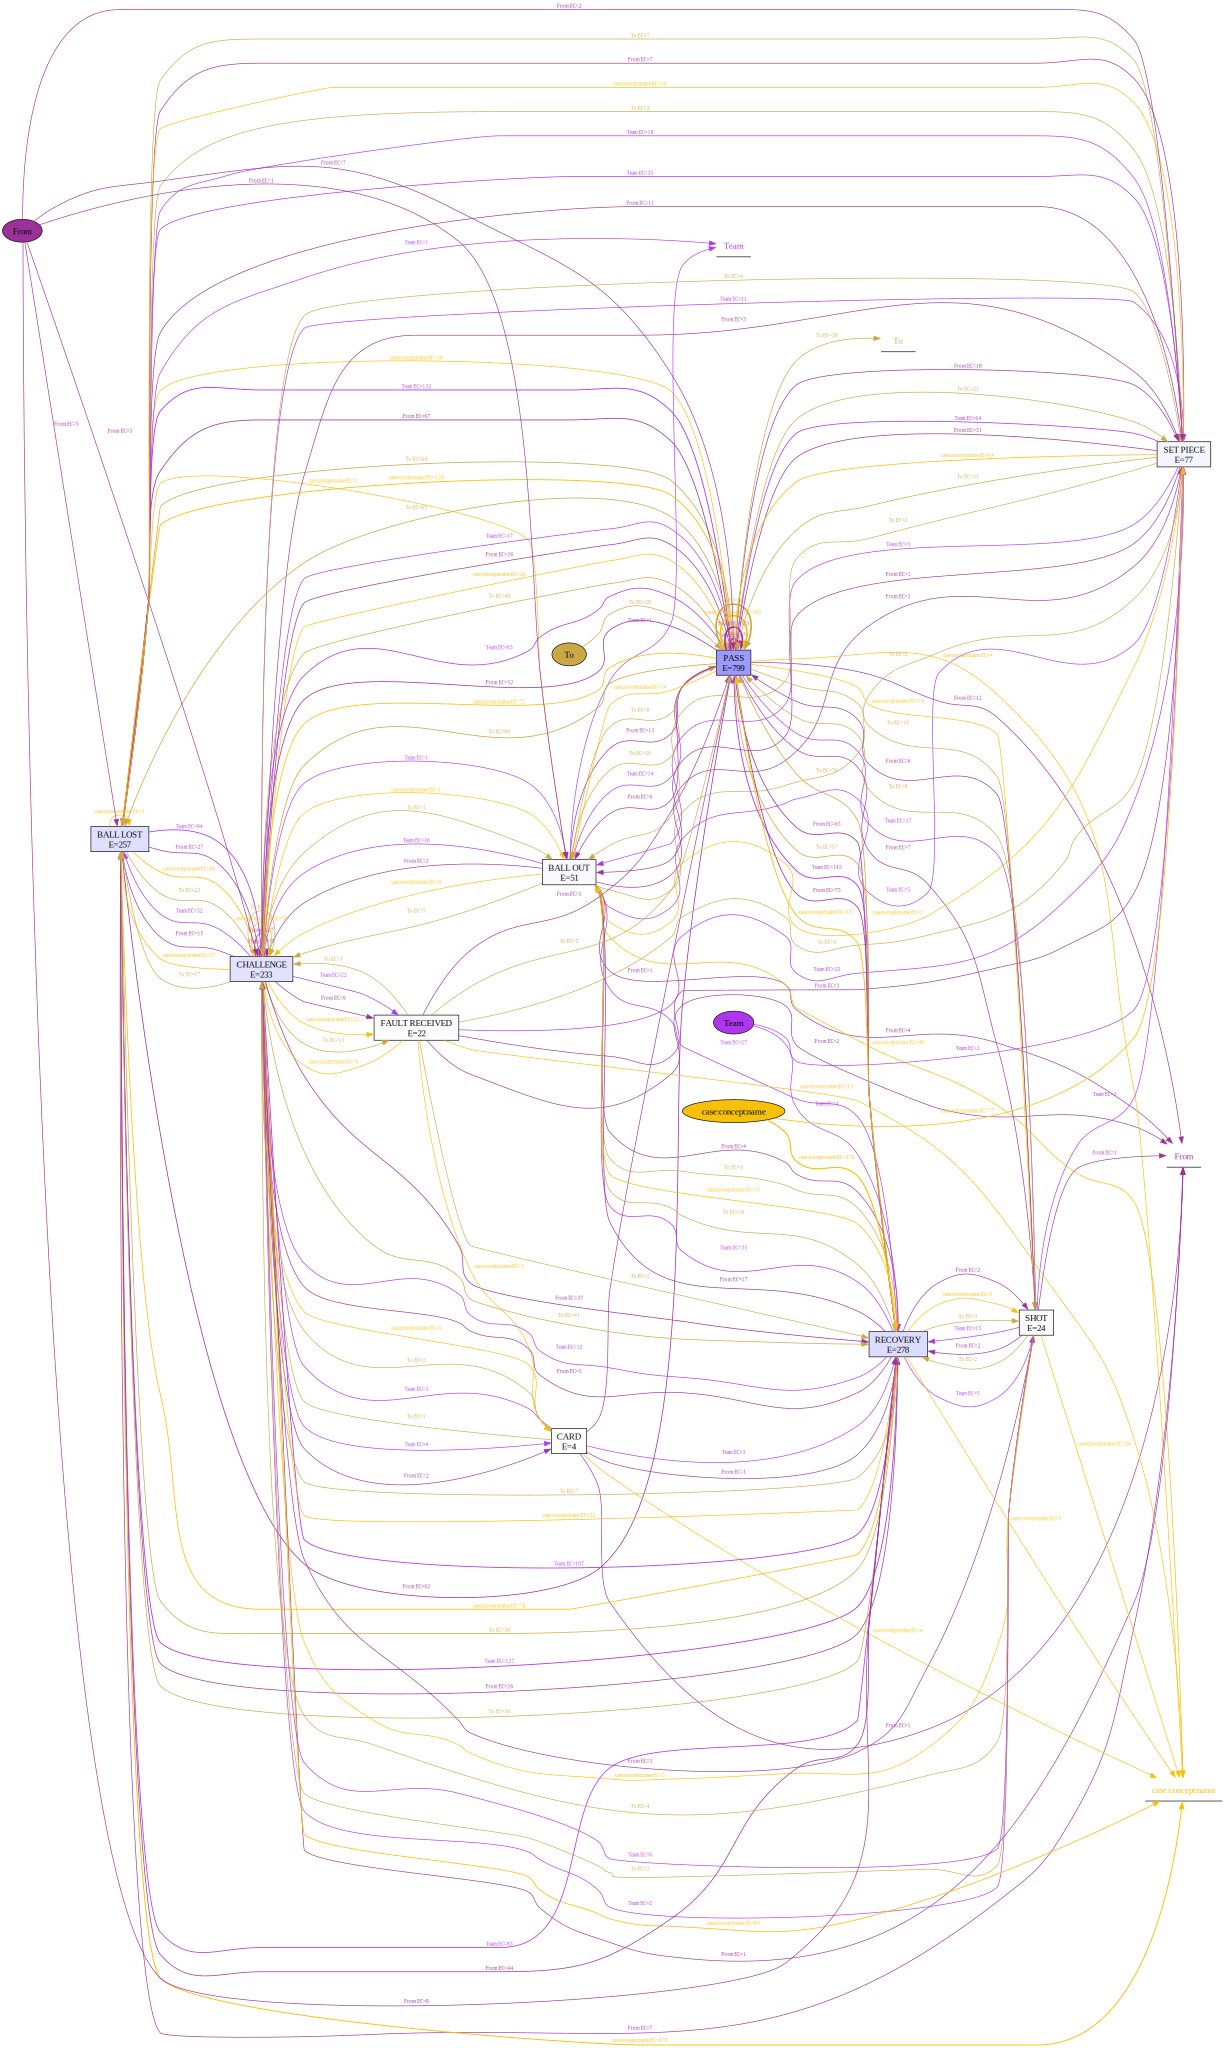

In [7]:
dfg=pm4py.ocel.discover_ocdfg(ocel)
pm4py.visualization.ocel.ocdfg.visualizer.apply(dfg)